In [1]:
import numpy as np
import matplotlib.pyplot as plt
from Module.Curve_Fitting_MLE import *
from scipy.optimize import minimize
plt.style.use('classic')

<br>
<font size = 15>Fitting Zipf's law:</font>
<br><br>
The Zipf's distribution is : <br>
\begin{equation}P_k=Ck^{-\alpha}\end{equation}
where the rank $k=[m, m+1, ..., n]$. The normalized condition gives:<br>
\begin{equation}1=\sum P_k=C\sum_{m}^{n}(\frac{1}{k^\alpha})\Rightarrow C=1/H(m,n,\alpha)\end{equation}
where $H(m,n,\alpha)\equiv \sum_{m}^{n}\frac{1}{k^\alpha}=\zeta(\alpha, m) - \zeta(\alpha, n+1)$, $\zeta(\alpha, m)$ is Hurwitz zeta function.<br>

Now give a raw data $X=[x_1,x_2,x_3...,x_N]$ where $x_i$ is the word of utterance (some words will repeat). The likelihood is:<br>
\begin{equation}L=\prod_{i=1}^{N}P(x_i|\alpha)=\prod_{i=1}^{k}P(y_i|\alpha)^{\rho(y_i)}=\prod_{i=1}^{k}\big[\frac{y_i^{-\alpha}}{H(y_1,y_k,\alpha)}\big]^{\rho(y_i)}\end{equation}
where $Y=[y_1, y_2...,y_k]$ is a ranking set of $\bf{non-repeat}$ $X$ with frequency $\rho(y_i)$


The maximum likelihood estimation (MLE) requires $L$ be maximum, and then $\ln(L)$ will also be max:<br>
\begin{equation}0=\frac{\partial\ln{L}}{\partial \alpha}=-\sum_{i=1}^{k}{\rho(y_i)\ln{y_i}}+\frac{N}{H(y_1,y_k,\alpha)}\sum_{i=1}^{k}\frac{\ln{(y_i)}}{y_i^{ \alpha}}\end{equation}

However we can't solve $\alpha$ exactly in this form. Instead, we use the minimize function in scipy:
\begin{equation}max(\ln L(\alpha))=min(-1*\ln L(\alpha))\end{equation}
\begin{equation}\Rightarrow \alpha = \alpha_1, C=1/H(y_1,y_k,\alpha_1)\end{equation}


Ps. This result is better than Eq.(38) in ref 1, where use $\zeta (y_1, \alpha)$ instead of $H(y_1,y_k,\alpha_1)$

<ref>Reference: <br>
1. https://arxiv.org/pdf/cond-mat/0412004.pdf Appendix.B
2. scipy.minimize: https://www.youtube.com/watch?v=cXHvC_FGx24
3. scipy minimize function with parameters: https://stackoverflow.com/questions/43017792/minimize-function-with-parameters


<br>
<font size = 15>What is goodness of fitting in MLE ?</font>
<br><br>
If we KNOW the distribution of experiment data (the error distribution) is normal distribution, the likelihood of getting the best fitting function can be written down as :
\begin{equation}L=\prod_{i=1}^{k}\frac{1}{\sqrt{2\pi}\sigma_i}e^{-(y_i - g(x_i))^2/(2\sigma_i^2)}\end{equation}


This likelihood is used to maximize the probability of finding the theortical vaule (fitting model $g(x_i)$) close to experiment value ($y_i$). When we apply this $L$ with MLE, we get the condition the $L=max(L)$ is :
\begin{equation}\chi^2 =\sum_{i=1}^{k}(y_i - g(x_i))^2/(2\sigma_i^2)\end{equation}
should be minimized.<br>

This will lead to the result in OLS(ordinary least square). However we don't know the distribution of our data, even the error bars. So we must fixed this standard of good of fitting here. The generalized case of fitting should use the likelihood we mentioned before:
\begin{equation}L=\prod_{i=1}^{N}g(x_i|\alpha)=\prod_{i=1}^{k}g(y_i|\alpha)^{\rho(y_i)}\end{equation}

......(to be continue)


<ref>Reference: <br>
1. https://arxiv.org/pdf/1505.02016.pdf Appendix.C
2. http://www3.stat.sinica.edu.tw/statistica/oldpdf/a16n39.pdf
3. https://arxiv.org/vc/cond-mat/papers/0402/0402322v1.pdf
4. https://arxiv.org/pdf/cond-mat/0402322.pdf
5. https://cran.r-project.org/web/packages/zipfR/zipfR.pdf


the best exponent of Zipf is 0.742019, C is 0.263698
the best exponent of Zipf-Mandelbrot is 2.026531, C is 9.322194, a is 5.116087
model 0 is Zipf, model 1 is Zipf-Mandelbrot
the best fit is model 1


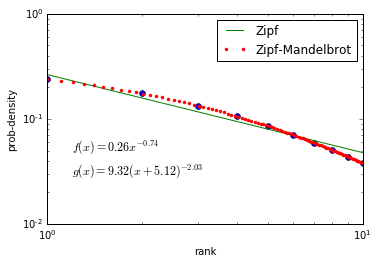

In [9]:
def main():
    '''
    Comparing two model: Zipf and Zipf_Mandelbrot, then we can decide the best fit by their aicc value.
    '''
    #raw data
    y = ([1,2,3,4,5,6,7,8,9,10], 
         [0.237764055,0.174683796,0.133742281,0.105672913,0.08559506,0.070739719
          ,0.059441014,0.050647964,0.043670949,0.038042249])

    Y = Two_to_One(y)
    
    #Estimate exponent. This action can make reduce the error of initial value guess.
    freq_M, freq_m = max(y[1]), min(y[1])
    rank_M, rank_m = max(y[0]), min(y[0])
    s_0 = np.log(freq_M/freq_m)/np.log(rank_M/rank_m)
    
    #fit Zipf: f(x)=C_Z/x^s_Z
    res_Z = minimize(L_Zipf, s_0, Y, method = 'SLSQP')
    s_Z = res_Z['x']
    t_Z = (int(min(y[0])), int(max(y[0])), s_Z)
    C_Z = 1 / incomplete_harmonic(t_Z)
    print('the best exponent of Zipf is %f, C is %f' % (s_Z, C_Z))
    
    #fit Zipf-Mandelbrot: g(x,a)=C_ZM/(x+a_ZM)^s_ZM
    res_ZM = minimize(L_Zipf_Mandelbrot, (s_0, 0), Y, method = 'CG')
    s_ZM = res_ZM['x'][0]
    a_ZM = res_ZM['x'][1]
    t_ZM = [int(min(y[0])), int(max(y[0])), s_ZM]
    C_ZM = 1 / incomplete_shifted_harmonic(t_ZM, a_ZM)
    print('the best exponent of Zipf-Mandelbrot is %f, C is %f, a is %f' % (s_ZM, C_ZM, a_ZM))

    #comparing their aic
    L = [L_Zipf(s_Z, Y), L_Zipf_Mandelbrot([s_ZM, a_ZM], Y)]
    k = [1,2]
    N = sum(y[1])
    print('model 0 is Zipf, model 1 is Zipf-Mandelbrot')
    aicc_index, aicc = AICc_choose(L, k, N)
    print('the best fit is model %d' % aicc_index)
    
    #draw raw data
    p = [i / N for i in y[1]]
    plt.plot(y[0], p, 'o')
    xdata = np.linspace(min(y[0]), max(y[0]), num = (max(y[0]) - min(y[0]))*10)
    
    #drawing fitting cruve
    theo_Z = Zipf_law(xdata, s_Z, C_Z)    
    plt.plot(xdata, theo_Z, 'g-', label = 'Zipf')
    
    theo_ZM = Zipf_Mandelbrot(xdata, s_ZM, C_ZM, a_ZM)
    plt.plot(xdata, theo_ZM, 'r.', label = 'Zipf-Mandelbrot')
    
    #show equation
    plt.text(1.2, 0.05,'$f(x)=%.2fx^{-%.2f}$' % (C_Z, s_Z), fontsize=12)
    plt.text(1.2, 0.03,'$g(x)=%.2f(x+%.2f)^{-%.2f}$' % (C_ZM, a_ZM, s_ZM), fontsize=12)
    
    plt.legend(loc = 'best')
    plt.yscale('log')
    plt.xscale('log')
    plt.ylabel('prob-density')
    plt.xlabel('rank')
    plt.gcf().subplots_adjust(left = 0.17, bottom = 0.17)
    plt.show()
    
if __name__ == '__main__':
    main()